In [225]:
import torch
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn

In [226]:
def create_data(n_samples=1000, noise=0.03):
    X, y = make_circles(n_samples=n_samples, noise=noise, random_state=42)
    return X, y

In [227]:
X, y = create_data()
df = pd.DataFrame({"cx" : X[:, 0], "cy": X[:, 1], "label": y})
df.head()

,cx,cy,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


<Axes: xlabel='cx', ylabel='cy'>

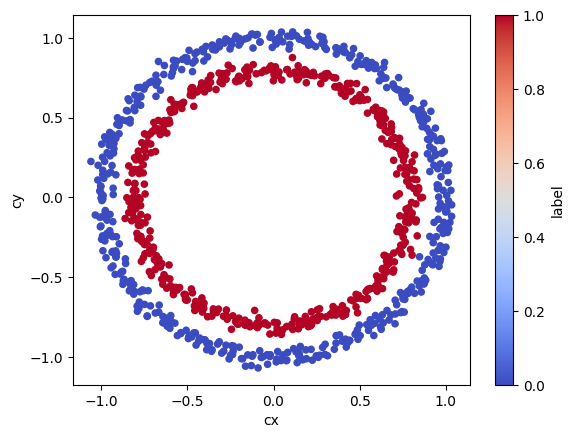

In [228]:
df.plot(kind="scatter", x="cx", y="cy", c="label", cmap="coolwarm")

## Start Neural Network

In [229]:
# Getting data
X_tensor = torch.from_numpy(X).type(torch.float)
y_tensor = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


In [230]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

#### Building of the Neural Network:
It will take 2 inputs (cx and cy), it will go through an hidden layer, and then will return a single output.
It will go from 2 inputs, to 5 neurons, to 1 output.

Why?

Because it allows the model to learn patterns from 5 numbers raather than just 2 numbers, potentially leading to better outputs.

In [231]:
class CircleClassificator(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x):
        return self.layer2(self.layer1(x))

In [232]:
model = CircleClassificator().to(device)

untrained_predicitons = model(X_test.to(device))
untrained_predicitons[:5]

tensor([[-0.3360],
        [-0.3714],
        [-0.3869],
        [-0.3210],
        [-0.6147]], grad_fn=<SliceBackward0>)

In [233]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true.squeeze(), y_pred.squeeze())
    return round(correct.sum().item() / len(correct), 4) * 100

def sigmoid_round(tensor):
    return torch.round(torch.sigmoid(tensor))

In [234]:
y_pred = torch.round(
    torch.sigmoid(
        model(X_test.to(device))
    )
)

accuracy_fn(y_test, y_pred)

50.0

#### Training

In [235]:

epochs = 100
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model.train()
    
    # 1. Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = sigmoid_round(y_logits)
    
    # 2. Calculate loss / accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    # 3. Optimizer mero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    # Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        y_logits = model(X_train).squeeze()
        y_pred = sigmoid_round(y_logits)
        
        # 2. Calculate loss / accuracy
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_train, y_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {loss:.5f}, Test acc: {acc:.2f}%")
    


Epoch: 0 | Loss: 0.71890, Accuracy: 50.00% | Test loss: 0.71890, Test acc: 50.00%
Epoch: 10 | Loss: 0.70096, Accuracy: 50.00% | Test loss: 0.70096, Test acc: 50.00%
Epoch: 20 | Loss: 0.69607, Accuracy: 47.63% | Test loss: 0.69607, Test acc: 47.63%
Epoch: 30 | Loss: 0.69465, Accuracy: 48.50% | Test loss: 0.69465, Test acc: 48.50%
Epoch: 40 | Loss: 0.69418, Accuracy: 48.88% | Test loss: 0.69418, Test acc: 48.88%
Epoch: 50 | Loss: 0.69398, Accuracy: 50.12% | Test loss: 0.69398, Test acc: 50.12%
Epoch: 60 | Loss: 0.69386, Accuracy: 50.38% | Test loss: 0.69386, Test acc: 50.38%
Epoch: 70 | Loss: 0.69377, Accuracy: 50.62% | Test loss: 0.69377, Test acc: 50.62%
Epoch: 80 | Loss: 0.69370, Accuracy: 50.50% | Test loss: 0.69370, Test acc: 50.50%
Epoch: 90 | Loss: 0.69364, Accuracy: 50.25% | Test loss: 0.69364, Test acc: 50.25%


It sucks because it's a linear model, and it basically draws a line that cuts the circle in half, guessing randomly. 

So the best thing to do is to use non-linear activation functions.

In [244]:
class CircleClassificator2(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
        

In [256]:
model = CircleClassificator2().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [258]:
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.51268, Accuracy: 92.00% | Test Loss: 0.54960, Test Accuracy: 87.50%
Epoch: 100 | Loss: 0.38687, Accuracy: 98.50% | Test Loss: 0.43547, Test Accuracy: 96.00%
Epoch: 200 | Loss: 0.25236, Accuracy: 99.50% | Test Loss: 0.30238, Test Accuracy: 98.00%
Epoch: 300 | Loss: 0.15470, Accuracy: 99.88% | Test Loss: 0.19881, Test Accuracy: 100.00%
Epoch: 400 | Loss: 0.09811, Accuracy: 100.00% | Test Loss: 0.13629, Test Accuracy: 100.00%
Epoch: 500 | Loss: 0.06581, Accuracy: 100.00% | Test Loss: 0.09732, Test Accuracy: 100.00%
Epoch: 600 | Loss: 0.04771, Accuracy: 100.00% | Test Loss: 0.07479, Test Accuracy: 100.00%
Epoch: 700 | Loss: 0.03697, Accuracy: 100.00% | Test Loss: 0.06122, Test Accuracy: 100.00%
Epoch: 800 | Loss: 0.02995, Accuracy: 100.00% | Test Loss: 0.05174, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.02502, Accuracy: 100.00% | Test Loss: 0.04491, Test Accuracy: 100.00%
